# Import libraries for SBI 

In [1]:
from joblib.externals.loky import set_loky_pickler
set_loky_pickler("dill")

from sbi.analysis import pairplot
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi #deprecated, removed in next release
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi import utils as utils

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import gaussian_kde

# Import libraries for TVB

In [2]:
%matplotlib widget

from tvb.simulator.lab import *
from tvb.simulator.plot.tools import *
from tvb.datatypes.time_series import TimeSeriesRegion
from simulation_wrapper import simulation_wrapper_func

from scipy import io
from scipy import signal
from scipy.io import savemat
import numpy as np
import scipy.stats
import time as tm
import h5py
import sys
import os
#import utils

In [3]:
prior_min = [2.6,17.6, 0.05, 0.025] #17.6
prior_max = [9.75,110.0, 0.15, 0.075]
prior_jr = BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.
   INFO  Projection configured gain shape (65, 374)


/home/jovyan/Downloads/TVB_Distribution/tvb_data/lib/python3.10/site-packages/numba/np/ufunc/gufunc.py:252: RuntimeWarning: overflow encountered in _numba_dfun_jr
  return self.ufunc(*args, **kwargs)
/home/jovyan/Downloads/TVB_Distribution/tvb_data/lib/python3.10/site-packages/tvb/simulator/coupling.py:372: RuntimeWarning: overflow encountered in exp
  (self.cmax - self.cmin) / (1.0 + numpy.exp(self.r * (self.midpoint - (x_j[:, 0] - x_j[:, 1]))))


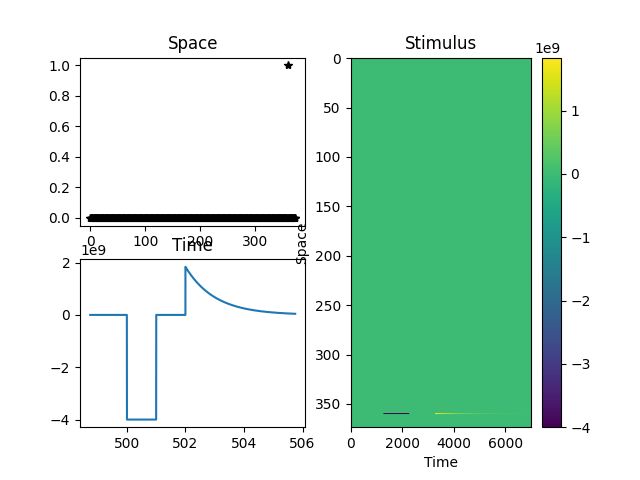

In [4]:
simulation_wrapper_prepared, prior_jr_prepared = prepare_for_sbi(simulation_wrapper_func, prior_jr);

In [5]:
# start clock for saving running time:
start_time = tm.time()

# Next, we need simulations, or more specifically, pairs of parameters theta
# which we sample from the prior and corresponding simulations x = simulator(theta).
# The sbi helper function called simulate_for_sbi allows to parallelize your code with joblib.
num_sim = 1
workers_num = 64
sim_params_jr, sim_eeg_jr = simulate_for_sbi(simulation_wrapper_prepared, proposal=prior_jr_prepared, num_simulations=num_sim, num_workers=workers_num);

end_time = tm.time()
sim_run_time = end_time - start_time

#print("simulation run time:", sim_run_time)

#print("sim_params_jr.shape", sim_params_jr.shape)
#print("sim_eeg_jr.shape", sim_eeg_jr.shape)

# detect and return # of NaN sim
nan_mask = torch.isnan(sim_eeg_jr[:,0])
num_nan = nan_mask.sum().item()
print("Number of NaN sim:",num_nan)

# detect and return # of Inf sim
inf_mask = torch.isinf(sim_eeg_jr[:,0])
num_inf = inf_mask.sum().item()
print("Number of Inf sim:",num_inf)

WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.
   INFO  Projection configured gain shape (65, 374)
Number of NaN sim: 0
Number of Inf sim: 0


In [ ]:
torch.save(sim_params_jr, 'sim_params_jr.pt')

In [6]:
np.save('sim_eeg_jr_374.npy', sim_eeg_jr)
#torch.save(sim_eeg_jr, 'sim_eeg_jr.pt')

In [ ]:
sim_params_jr = torch.load('sim_params_jr.pt');
sim_eeg_jr = torch.load('sim_eeg_jr.pt');

In [ ]:
time = np.linspace(0,30,120000)
plt.figure(figsize=(7,10))
plt.plot(time[2000:8000],sim_eeg_jr[0,2000:8000,:],'k')

In [ ]:
#chunks = torch.chunk(sim_eeg_jr, 10, dim=0)

#for i, chunk in enumerate(chunks):
    #chunk_numpy = chunk.numpy()
    #np.save(f'data_chunk_{i+1}.npy', chunk_numpy)

In [ ]:
mat = h5py.File('avg_final.mat', 'r')
signal = torch.tensor(mat['avg_final'][:])

In [ ]:
signal = signal.permute(2,0,1)
signal = signal[:,:,:]/600;
signal = np.delete(signal, [52,55], 2)

In [ ]:
plt.figure(figsize=(7,10))
plt.plot(np.linspace(-50, 200, 1001),signal[0,:,:],'k')
plt.ylim(-0.02, 0.02)
print(signal.shape)

In [ ]:
num_simulations = sim_eeg_jr.shape[0]  #total number of simulations, which is 10k
initial_offset = 250 * 4  #index of the first stimulation
samples_per_stimulation = 500 * 4  #distance between stimulations
pre_stimulus = 50 * 4  #window of samples before the stimulation
post_stimulus = 200 * 4  #window of samples after the stimulation
window_size = pre_stimulus + post_stimulus  #total size of the window around each stimulation

#initialize an empty list to store the average window for each simulation
averaged_trials = []

#loop through each simulation to extract, average, and store windows
for sim in range(num_simulations):
    windows = []  #temporary list to store windows for the current simulation

    #generate indices for stimulations, starting from `initial_offset` and spaced by `samples_per_stimulation`
    stim_indices = torch.arange(initial_offset, sim_eeg_jr.shape[1] - samples_per_stimulation, samples_per_stimulation)
    
    #for each stimulation point in the current simulation
    for idx in stim_indices:
        start_idx = idx - pre_stimulus  #start of window
        end_idx = idx + post_stimulus  #end of window
        
        #extract the window of data around the current stimulation for all channels
        #shape of `window` will be (window_size, 65)
        window = sim_eeg_jr[sim, start_idx:end_idx, :]  
        
        #append the extracted window to the `windows` list
        windows.append(window)

    #stack all windows for the current simulation along a new dimension
    #`windows` now has shape (num_trials, window_size, 65), where num_trials is the number of stimulations
    windows = torch.stack(windows, dim=0)
    
    #calculate the mean across all trials for the current simulation
    #resulting shape: (window_size, 65)
    avg_trial = windows.mean(dim=0)
    
    #append the averaged window for this simulation to the list `averaged_trials`
    averaged_trials.append(avg_trial)

#stack all simulations' averaged windows along a new dimension to get the final result
#`final_result` now has shape (10k, window_size, 65)
final_result = torch.stack(averaged_trials, dim=0)

#print the shape to verify it matches (10k, window_size, 65)
print(final_result.shape)  #should output: (10k, 1000, 65)

In [ ]:
# Next, we instantiate the inference object 
inference = SNPE(prior=prior_jr)
print(inference)

# We then pass the simulated data to the inference object.
sim_eeg_jr_compare = signal.reshape(10_000, -1)
sim_eeg_jr_compare = sim_eeg_jr_compare.float()
sim_eeg_jr_compare.shape

In [ ]:
inference_jr = inference.append_simulations(sim_params_jr, sim_eeg_jr_compare)

# Next, we train the neural density estimator to learn the association
# between the simulated data (or data features) and the underlying parameters:
density_estimator_forward = inference_jr.train()

In [ ]:
# Finally, we can use the density estimator to the built the posterior distribution.
# Meaning, the distributions over the parameters given the data.
posterior_jr = inference_jr.build_posterior(density_estimator_forward, sample_with='mcmc')
print(posterior_jr) # prints how the posterior was trained

In [ ]:
mat = scipy.io.loadmat('avg_trial.mat')
signal = mat['avg_trial']
sim_eeg_obs = torch.tensor(signal.T)
sim_eeg_obs = np.delete(sim_eeg_obs, [52,55], 1)

# Now, we would generate the "experimental" observation.
sim_params_jr_true = torch.tensor([[ 6.3861, 66.3435,  1.3794,  0.8769]])
#sim_eeg_obs = simulation_wrapper_prepared(sim_params_jr_true)

In [ ]:
# # plot EEG
teeg = np.linspace(-50,200,1001)
plt.figure(figsize=(7,10))
plt.plot(teeg[:],sim_eeg_obs[:,:],'k')
plt.ylim(-0.05, 0.05)
plt.title("All EEG channels")

plt.figure(figsize=(7,10))
plt.plot(teeg[:],sim_eeg_obs[:,0], teeg[:],sim_eeg_obs[:,1], 'k')
plt.ylim(-0.05, 0.05)
plt.title("EEG channel 1-2")

plt.tight_layout()

In [ ]:
avg_trial_remodel = sim_eeg_obs.reshape(-1)
avg_trial_remodel.shape

In [ ]:
# given the observation, we can sample from the posterior our p(theta|x_obs) and visualise the marginals for the parameters.
samples = posterior_jr.sample((1000,), x=avg_trial_remodel)

In [ ]:
pairplot(samples, points=sim_params_jr_true, limits=[[2.6,9.75], [17.6,110.0], [1.5,2.5], [0.75,1.25]], figsize=(6, 6), labels=[r"$A$", r"$B$", r"$a$", r"$b$"])

In [ ]:
# select max posterior for all parameters and run
numsamples = 1000
# post_values = posterior_jr.sample((numsamples,),x=sim_eeg_obs_compare)
post_values_A = samples[:,0]
post_values_B = samples[:,1]
post_values_a = samples[:,2]
post_values_b = samples[:,3]
kde_sim_A = gaussian_kde(post_values_A, bw_method='scott')
kde_sim_B = gaussian_kde(post_values_B, bw_method='scott')
kde_sim_a = gaussian_kde(post_values_a, bw_method='scott')
kde_sim_b = gaussian_kde(post_values_b, bw_method='scott')

x_grid_A = np.linspace(2.6,9.75, numsamples)
pdf_values_A = kde_sim_A.evaluate(x_grid_A)
value_opt_index_A = np.argmax(pdf_values_A)
value_opt_A = x_grid_A[value_opt_index_A]

x_grid_B = np.linspace(17.6,110.0, numsamples)
pdf_values_B = kde_sim_B.evaluate(x_grid_B)
value_opt_index_B = np.argmax(pdf_values_B)
value_opt_B = x_grid_B[value_opt_index_B]

x_grid_a = np.linspace(1.5,2.5, numsamples)
pdf_values_a = kde_sim_a.evaluate(x_grid_a)
value_opt_index_a = np.argmax(pdf_values_a)
value_opt_a = x_grid_a[value_opt_index_a]

x_grid_b = np.linspace(0.75,1.25, numsamples)
pdf_values_b = kde_sim_b.evaluate(x_grid_b)
value_opt_index_b = np.argmax(pdf_values_b)
value_opt_b = x_grid_b[value_opt_index_b]

In [ ]:
tensor_pm_true = sim_params_jr_true[0]

plt.figure(figsize=(5,5))
x_pdf_A =np.linspace(2.6,9.75,numsamples)
plt.plot(x_pdf_A,pdf_values_A,linewidth=0.5)
plt.plot(x_pdf_A[value_opt_index_A], pdf_values_A[value_opt_index_A], 'ro')
plt.axvline(tensor_pm_true[0], color='orange')
plt.title("PDF A")
plt.legend(["PDF","SBI A","True A"])
plt.show()

plt.figure(figsize=(5,5))
x_pdf_B =np.linspace(17.6,110.0,numsamples)
plt.plot(x_pdf_B,pdf_values_B,markevery=value_opt_index_B,linewidth=0.5)
plt.plot(x_pdf_B[value_opt_index_B], pdf_values_B[value_opt_index_B], 'ro')
plt.axvline(tensor_pm_true[1], color='orange')
plt.title("PDF B")
plt.legend(["PDF","SBI B","True B"])
plt.show()

plt.figure(figsize=(5,5))
x_pdf_a =np.linspace(1.5,2.5,numsamples)
plt.plot(x_pdf_a,pdf_values_a,linewidth=0.5)
plt.plot(x_pdf_a[value_opt_index_a], pdf_values_a[value_opt_index_a], 'ro')
plt.axvline(tensor_pm_true[2], color='orange')
plt.title("PDF a")
plt.legend(["PDF","SBI a","True a"])
plt.show()

plt.figure(figsize=(5,5))
x_pdf_b =np.linspace(0.75,1.25,numsamples)
plt.plot(x_pdf_b,pdf_values_b,markevery=value_opt_index_b,linewidth=0.5)
plt.plot(x_pdf_b[value_opt_index_b], pdf_values_b[value_opt_index_b], 'ro')
plt.axvline(tensor_pm_true[3], color='orange')
plt.title("PDF b")
plt.legend(["PDF","SBI b","True b"])
plt.show()

In [ ]:
params_sbi_jr = torch.tensor([[value_opt_A,value_opt_B, value_opt_a, value_opt_b]])
eeg_sbi = simulation_wrapper_prepared(params_sbi_jr)

In [ ]:
print(params_sbi_jr)

In [ ]:
np.save('final_simulation.npy', eeg_sbi)

In [ ]:
mat = h5py.File('pre_final_sim.mat', 'r')
signal = torch.tensor(mat['avg_final_chunk'][:])
eeg_sbi = signal

In [ ]:
print(eeg_sbi.shape)

In [ ]:
eeg_sbi = np.delete(eeg_sbi, [52,55], 0)

In [ ]:
initial_offset = 250 * 4  #index of the first stimulation

windows = []  #temporary list to store windows for the current simulation

#generate indices for stimulations, starting from `initial_offset` and spaced by `samples_per_stimulation`
stim_indices = torch.arange(initial_offset, eeg_sbi.shape[1] - samples_per_stimulation, samples_per_stimulation)
    
#for each stimulation point in the current simulation
for idx in stim_indices:
    start_idx = idx - pre_stimulus  #start of window
    end_idx = idx + post_stimulus  #end of window

    window = eeg_sbi[0, start_idx:end_idx, :]  
        
    #append the extracted window to the `windows` list
    windows.append(window)

windows = torch.stack(windows, dim=0)
    
#calculate the mean across all trials for the current simulation
avg_eeg_sbi = windows.mean(dim=0)
    
print(avg_eeg_sbi.shape)

In [ ]:
teeg = np.linspace(-50,200,1001)

In [ ]:
plt.figure(figsize=(7,10))
plt.subplot(2,1,1)
plt.plot(teeg[:], sim_eeg_obs[:,:],'k')
plt.ylim(-0.02,  0.02)
plt.title("EEG - OBS, channel 1-65")

plt.subplot(2,1,2)
plt.plot(teeg[:], eeg_sbi[:,:].T/40000,'k')
plt.ylim(-0.02,  0.02)
plt.title("EEG - SBI, channel 1-65")

plt.tight_layout()

In [ ]:
#numpy.save('Time', teeg)
#numpy.save('SBI EEG', eeg_sbi)